# Running a quantum computation on IBM hardware

this notebook will walk you through an actual _quantum_ computation.

We will define a simple circuit, connect to IBMQ's runtime service, and sample our circuit using an available quantum computer.

First of all, make sure you are registered on [IBM quantum](https://quantum.ibm.com). Create an IBMid by clicking on "Create an IBMid", and follow the instructions.

You will get an API token, which will allow you to connect to the hardware. Your token is displayed on the top right of your homepage.

Let's start by installing qiskit and qiskit_ibm_runtime, which allows us to connect to IBM's online service.

In [10]:
#%pip install qiskit[visualization] --quiet
#%pip install qiskit_ibm_runtime --quiet
#%pip install matplotlib --quiet
#%pip install qiskit-aer --quiet

This parametrized circuit will be a simple example for us to try out hardware.

It's got few gates and qubits, because we don't want to waste too much of our precious access time.

Essentially, as we vary the parameter $\phi$, we get from a computational basis state to an entangled one, then back to a computational basis state.

In our quantum computation, we will get the expectation values of some observables for multiple values of $\phi$.

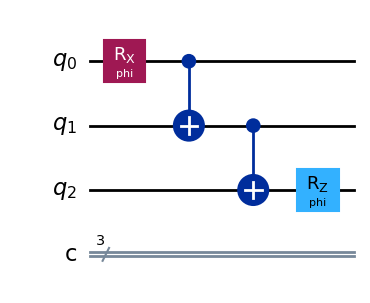

In [11]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter

circuit = QuantumCircuit(3, 3)
phi = Parameter("phi")
circuit.rx(phi, 0)
circuit.cx(0, 1)
circuit.cx(1, 2)
circuit.rz(phi, 2)

circuit.draw("mpl")

We will measure the $ZZZ$ Pauli string and the $XXX$ Pauli string. Below, I define the Pauli strings and add them in an observable array.

In [12]:
from qiskit.quantum_info import SparsePauliOp

observables_labels = ["XXX", "ZZZ"]
observables = [[SparsePauliOp(label)] for label in observables_labels]


Let's define some helper functions to reuse through the notebook: one to sample the bitstrings, and one to estimate the observables, as well as the accompanying helper functions.

In [13]:
from qiskit.quantum_info import Statevector
from qiskit.primitives import StatevectorEstimator
import numpy as np
import matplotlib.pyplot as plt

# we input a circuit and a number of samples, and obtain a dictionary of outcomes
def sample_circuit(circuit: QuantumCircuit,n_shots:int,parameters:list=None) -> dict:
    if parameters is None:
        parameters = np.zeros((len(circuit.parameters),))
    circuit = circuit.assign_parameters({p_circ: p_val for p_circ,p_val in zip(circuit.parameters,parameters)})
    statevector = Statevector.from_instruction(circuit)
    outcomes = statevector.sample_counts(n_shots)
    return outcomes


def sv_estimate_observables(
    circuit: QuantumCircuit, observables: list, param_sweep: np.ndarray
):
    estimator = StatevectorEstimator()
    pub = (circuit, observables, param_sweep)
    job = estimator.run([pub])
    result = job.result()[0]
    return result


# function that print all the outcomes
def print_outcomes(outcomes: dict):
    for bitstring, counts in outcomes.items():
        print(f"Obtained bitstring |{bitstring}> {counts} times.")

# plot result of simulation
def plot_estimator_result(result, param_sweep, observables,overlay_param_sweep=None,overlay_result=None):
    fig, ax = plt.subplots()
    ax:plt.Axes

    if overlay_result is not None and overlay_param_sweep is not None:
        for ov_evs in overlay_result.data.evs:
            ax.plot(overlay_param_sweep, ov_evs,color=".5",linewidth=.5)
    for evs,stds,obs in zip(result.data.evs,result.data.stds,observables):
        ax.errorbar(param_sweep, evs,stds, label=obs[0].paulis[0])
    ax.legend()
    ax.set_xlabel("$\phi$")
    ax.set_ylabel("Expectation value")
    ax.set_xlim([-np.pi,np.pi])
    plt.show()


First, we perform a statevector simulation to compute the expectation values: this is the ideal outcome of the $\phi$ sweep. We sweep $\phi$ between $-\pi$ and $\pi$, with `n_params` defining the number of steps in the sweep.

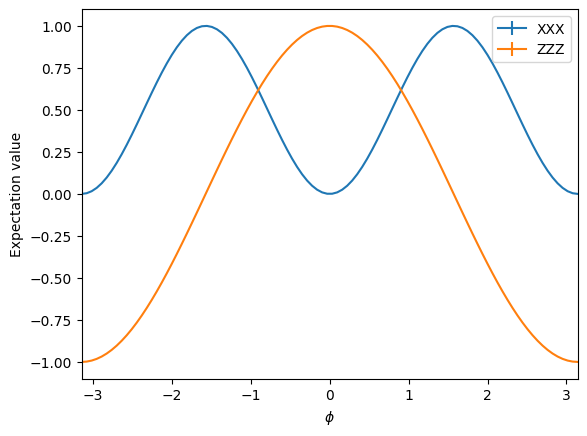

In [14]:
n_params = 100
fine_param_sweep = np.linspace(-np.pi, np.pi, n_params)

ideal_result = sv_estimate_observables(
    circuit=circuit, observables=observables, param_sweep=fine_param_sweep
)
plot_estimator_result(result=ideal_result, param_sweep=fine_param_sweep, observables=observables)

Let's take a look at the bitstring counts as we sweep $\phi$. We use our sampler function to see the ratio of bitstring as $\phi$ changes.

Text(0, 0.5, 'Bitstring count')

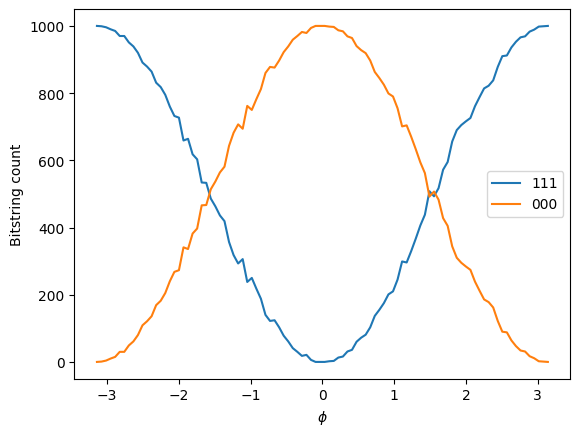

In [15]:
outcomes={}
n_shots=1000
bitstring_counts={}

# rearrange the dictionaries to get a plottable object
for p in fine_param_sweep:
    outcomes[p] = sample_circuit(circuit=circuit,n_shots=n_shots,parameters=[p])
for ind,k in enumerate(outcomes.keys()):
    for bitstring, counts in outcomes[k].items():
        if bitstring not in bitstring_counts.keys():
            bitstring_counts[bitstring]=np.zeros((len(list(outcomes.keys()))))
        bitstring_counts[bitstring][ind]=counts


fig,ax = plt.subplots()
for bitstring in bitstring_counts.keys():
    ax.plot(fine_param_sweep,bitstring_counts[bitstring],label=bitstring)
ax.legend()
ax.set_xlabel("$\phi$")
ax.set_ylabel("Bitstring count")

We now connect to the real quantum computer. You'll need to input your access token. You may directly copy-paste your token in the notebook like so: `token = "abcd12345"`.

Using the `least_busy` method, we fetch the least occupied IBM device.

We specify that we don't want a `simulator`, and that the computer should currently be `operational`. We also set the minimal number of qubits we require.

In [16]:
from qiskit_ibm_runtime import QiskitRuntimeService

token = "8587d453fc4802634c0c9ed4bd7ffcb2bc35171cedc0026f964732de58e2f02d910530b93239b25afd0e1c39b8a18d448ab81b677a69b2b93de9655f49067214"
service = QiskitRuntimeService(channel="ibm_quantum", token=token)

real_backend = service.least_busy(simulator=False, operational=True,min_num_qubits=3)

Before jumping in the real hardware simulation, let's make sure our measure works correctly by simulating real hardware, with the use of a _fake backend_. We can use those to mimick the behaviour of real hardware, noise and all. I've picked FakeAthensV2, but there's a [whole list](https://docs.quantum.ibm.com/api/qiskit/0.37/providers_fake_provider) of fake backends you can choose from.

Note that we need to be succesfully connected to IBM's servers to run these fake simulations, as the backend data live there.

Okay, so we run our evaluation of the $ZZZ$ and $XXX$ observables again, this time using the fake hardware, and not an ideal statevector simulation.

Again, make sure the cell above ran correctly and that you are properly connected to the RuntimeService. Otherwise, you may not get any results, or maybe an error.

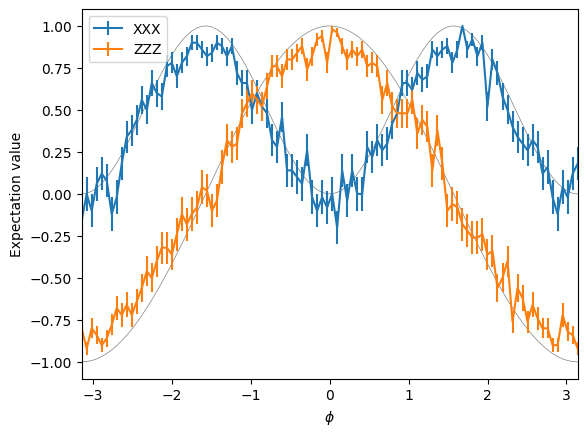

In [17]:
from qiskit_ibm_runtime.fake_provider import FakeAthensV2
from qiskit_ibm_runtime import EstimatorV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator

def backend_estimate_observables(
    backend, circuit: QuantumCircuit, observables: list, param_sweep: np.ndarray,n_shots:int
):
    estimator = EstimatorV2(backend)
    pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
    isa_circuit = pm.run(circuit)

    mapped_observables = [
        [observable[0].apply_layout(isa_circuit.layout)] for observable in observables
    ]

    # now you specify precision rather than shots, but for our estimator, it's just
    # shots = int(np.ceil(1.0 / precision**2))

    job = estimator.run([(isa_circuit, mapped_observables, param_sweep)],precision=np.sqrt(1/n_shots))
    result = job.result()[0]
    return result

n_shots=100
fake_backend = FakeAthensV2()
backend_sim = AerSimulator.from_backend(fake_backend)
fake_result = backend_estimate_observables(
    backend=backend_sim, circuit=circuit, observables=observables, param_sweep=fine_param_sweep,n_shots=n_shots
)

plot_estimator_result(
    result=fake_result,
    param_sweep=fine_param_sweep,
    observables=observables,
    overlay_param_sweep=fine_param_sweep,
    overlay_result=ideal_result
    )

Now, we run the job on the quantum device. You can see the progress on the [jobs page](https://quantum.ibm.com/jobs).

Be careful though: you only get 10 free minutes of hardware time per *month*!

The example below should take 5 seconds of hardware time, with most of the wait due to the queue (which doesn't count towards your free minutes).

If you've already run the job and want to reload the results without using more computation time, you can load the job using its key (something that looks like `crx13dfamspg1184b9xg` for example). In the code below, you can simply change the `which` variable from `run` to `load`. On your IBM homepage, you can find the job IDs on the left of the jobs list.

In the very end, we plot the real hardware result alongside a fake backend reconstruction to see whether it was a good approximation of the real hardware.

In order to run the job, set which to "run"

In [18]:
n_shots = 10
sparse_param_sweep=np.array((-2,-1,0,1,2))
which = "load"

if which == "run":
    real_result=backend_estimate_observables(real_backend,circuit,observables=observables,param_sweep=sparse_param_sweep,n_shots=n_shots)
elif which == "load":
    job_key='csymtyvkdtz000831fkg'
    job = service.job(job_key)
    real_result = job.result()[0]


print("HARDWARE RESULT")
# plot hardware results
plot_estimator_result(
    result=real_result,
    param_sweep=sparse_param_sweep,
    observables=observables,
    overlay_param_sweep=fine_param_sweep,
    overlay_result=ideal_result
    )


print("FAKE HARDWARE RESULT")
# simulate hardware results
n_shots = 10
fake_mimic_result = backend_estimate_observables(
    backend=AerSimulator.from_backend(real_backend),
    circuit=circuit,
    observables=observables,
    param_sweep=sparse_param_sweep,
    n_shots=n_shots
)

# plot simulated hardware results
plot_estimator_result(
    result=fake_mimic_result,
    param_sweep=sparse_param_sweep,
    observables=observables,
    overlay_param_sweep=fine_param_sweep,
    overlay_result=ideal_result
    )

Alright, we've done an actual computation on a quantum computer! Next week, we'll do something that has actual value, rather than sweeping an arbitrary circuit.